# 3D projection

In [38]:
import numpy as np
# setup camera with a simple camera matrix P
f=1000
cx=200
cy=200
K=np.array([[f,0,cx], [0,f,cy],[0,0,1]])
I=np.eye(3) # i.e., R 
t=np.array([[0],[0],[0]])
P=np.dot(K,np.hstack((I,t)))

def project(P, X): #X is an array of 3D points
    x=np.dot(P,X)
    for i in range(3): #convert to inhomogeneous coordinates
        x[i]/=x[2]
    return x

In [39]:
#load data
points_3D = np.loadtxt("house.p3d").T    # T means transpose
points_3D = np.vstack((points_3D, np.ones(points_3D.shape[1])))

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_18156\4248247713.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax=fig.gca(projection="3d")


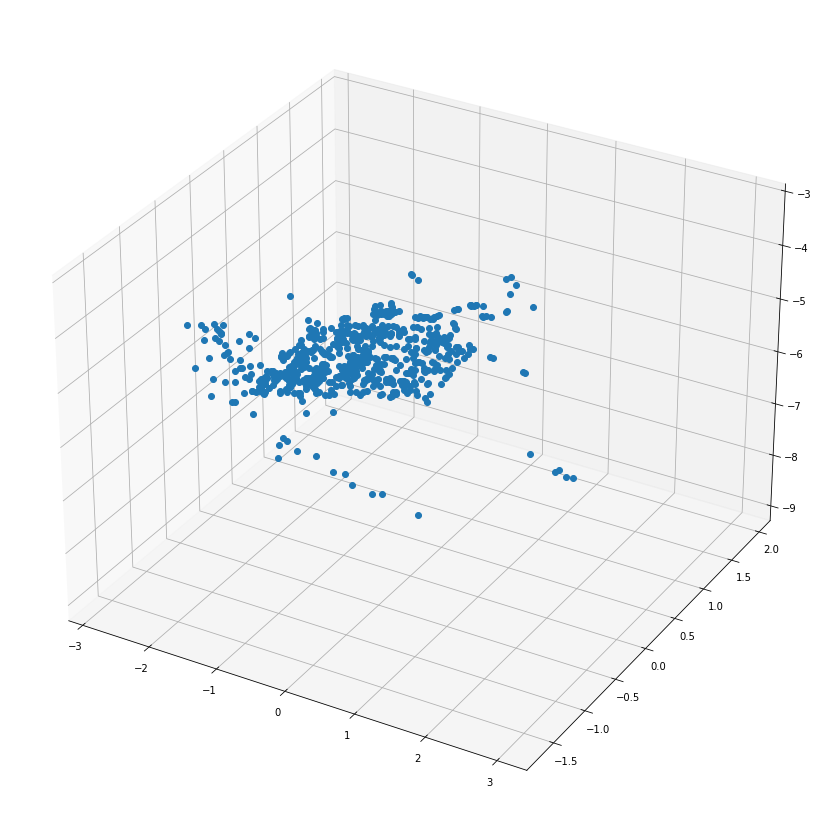

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

fig=plt.figure(figsize=[15,15])

ax=fig.gca(projection="3d")
ax.view_init(elev=None, azim=None) # you can set evaluation and azimuth with different values

ax.plot(points_3D[0], points_3D[1], points_3D[2], "o")

plt.draw()
plt.show()

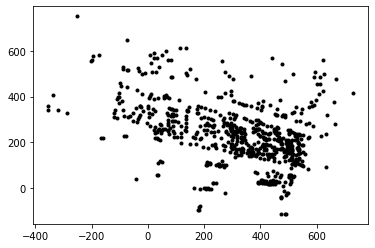

In [41]:
#projection
points_2D = project(P, points_3D)

#plot projection
from matplotlib import pyplot as plt
plt.plot(points_2D[0], points_2D[1], "k.")
plt.show()

# Camera pose estimation - Estimation of the camera matrix (projection matrix) P

In [42]:
print(points_2D.shape)
print(points_3D.shape)

(3, 672)
(4, 672)


In [43]:
n_points=6
points_3D_sampled = points_3D[:,:n_points]
points_2D_sampled = points_2D[:,:n_points]

A=np.zeros((2*n_points, 12), np.float32)
for i in range(n_points):
    A[2*i,:4] = points_3D_sampled[:,i].T
    A[2*i,8:12] = -points_2D_sampled[0,i]*points_3D_sampled[:,i].T
    A[2*i+1,4:8] = points_3D_sampled[:,i].T 
    A[2*i+1,8:12] = -points_2D_sampled[1,i]*points_3D_sampled[:,i].T


In [44]:
from scipy import linalg
p = linalg.solve(A, np.zeros((12,1), np.float32))
print(p)

[[-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]]


C:\Users\Nicolas\AppData\Local\Temp\ipykernel_18156\1225673925.py:2: LinAlgWarning: Ill-conditioned matrix (rcond=5.95202e-12): result may not be accurate.
  p = linalg.solve(A, np.zeros((12,1), np.float32))


In [45]:
U,S,V = linalg.svd(A)
minS = np.min(S)
condition = (S==minS)
minID = np.where(condition)
print("index of the smallest singular value is: ", minID[0])

index of the smallest singular value is:  [11]


In [46]:
P_hat = V[minID[0],:].reshape(3,4)/minS
print(P)
print(P_hat)

[[1000.    0.  200.    0.]
 [   0. 1000.  200.    0.]
 [   0.    0.    1.    0.]]
[[-3.2804388e+05 -6.4940880e+01 -6.5655703e+04 -1.6791176e+02]
 [ 1.8072113e+01 -3.2809128e+05 -6.5654727e+04 -1.9100063e+02]
 [ 2.9345358e-02 -1.4008930e-01 -3.2814072e+02 -2.9075453e-01]]


In [47]:
x_P_hat = project(P_hat, points_3D_sampled[:,0])
print(x_P_hat)

[452.53230098  14.43310316   1.        ]


In [48]:
x_P = points_2D_sampled[:,0]
print(x_P)

[452.53227678  14.43312958   1.        ]


In [49]:
x_P = points_2D
x_P_hat = project(P_hat, points_3D)

dist=0
for i in range(x_P.shape[1]):
    dist+=np.linalg.norm(x_P[:,i]-x_P_hat[:,i])
dist/=x_P.shape[1]
print(dist)

0.024904353536558482


Vary n_points in the range [10%, 20%, ..., 100%] of the number of points in points_3D and measure the corresponding dist:

In [50]:
proportions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

min_dist = 111111
best_p = 0

for p in proportions:
    n_points = int(p*points_3D.shape[1])
    points_3D_sampled = points_3D[:,:n_points]
    points_2D_sampled = points_2D[:,:n_points]

    A=np.zeros((2*n_points, 12), np.float32)
    for i in range(n_points):
        A[2*i,:4] = points_3D_sampled[:,i].T
        A[2*i,8:12] = -points_2D_sampled[0,i]*points_3D_sampled[:,i].T
        A[2*i+1,4:8] = points_3D_sampled[:,i].T 
        A[2*i+1,8:12] = -points_2D_sampled[1,i]*points_3D_sampled[:,i].T

    U,S,V = linalg.svd(A)
    minS = np.min(S)
    condition = (S==minS)
    minID = np.where(condition)
    P_hat = V[minID[0],:].reshape(3,4)/minS

    x_P_hat = project(P_hat, points_3D_sampled[:,0])
    x_P = points_2D_sampled[:,0]
    x_P = points_2D
    x_P_hat = project(P_hat, points_3D)

    dist=0
    for i in range(x_P.shape[1]):
        dist+=np.linalg.norm(x_P[:,i]-x_P_hat[:,i])
    dist/=x_P.shape[1]

    print(n_points, dist)

    if dist < min_dist:
        min_dist = dist
        best_p = p 

print("best number of points ", int(best_p*points_3D.shape[1]))
print("min dist", min_dist)    

67 0.0009587426051759949
134 0.002215880217778118
201 0.00311611500838038
268 0.002044196648069612
336 0.0012105340156304456
403 0.0018906513076554132
470 0.002424703709686834
537 0.0020585490424626118
604 0.0013096952723758697
672 0.0017848411788434777
best number of points  67
min dist 0.0009587426051759949


# 3D reconstruction - Homography

Number of detected keypoints in img1: 25477
Number of detected keypoints in img2: 24552


(-0.5, 3871.5, 1295.5, -0.5)

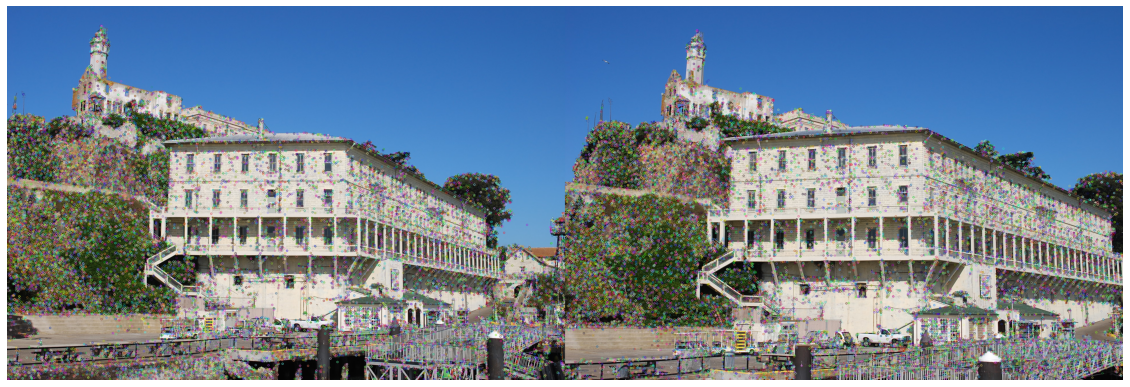

In [51]:
import homography
import sfm
import ransac
import  cv2 as cv
import numpy as np

sift = cv.SIFT_create()
# sift = cv.xfeatures2d.SIFT_create()

img1 = cv.imread("alcatraz1.jpg")
img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
kp1, des1 = sift.detectAndCompute(img1_gray, None)

img2 = cv.imread("alcatraz2.jpg")
img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
kp2, des2 = sift.detectAndCompute(img2_gray, None)

img1_kp = img1.copy()
img1_kp = cv.drawKeypoints(img1, kp1, img1_kp)
print("Number of detected keypoints in img1: %d" % (len(kp1)))

img2_kp = img2.copy()
img2_kp = cv.drawKeypoints(img2, kp2, img2_kp)
print("Number of detected keypoints in img2: %d" % (len(kp2)))

img1_2_kp = np.hstack((img1_kp, img2_kp))

plt.figure(figsize=(20,10))
plt.imshow(img1_2_kp[:,:,::-1])
plt.axis("off")


In [52]:
bf = cv.BFMatcher(crossCheck=True) # crossCheck = True means we want to find consistent matching
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x:x.distance)
print("Number of consistent matches: %d"%len(matches))

Number of consistent matches: 9690


(-0.5, 3871.5, 1295.5, -0.5)

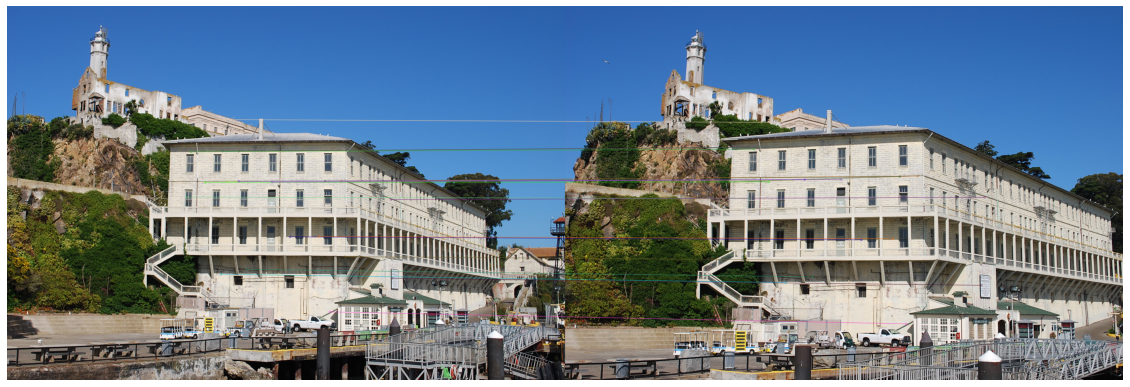

In [53]:
img1_2_matches = cv.drawMatches(img1, kp1, img2, kp2, 
                                matches[:20], None,
                                flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20,10))
plt.imshow(img1_2_matches[:,:,::-1])
plt.axis("off")

In [54]:
n_matches = 1000

kp1_array=np.zeros((2,n_matches), np.float32)
for i in range(n_matches):
    kp1_array[0][i]=kp1[matches[i].queryIdx].pt[0]
    kp1_array[1][i]=kp1[matches[i].queryIdx].pt[1]

kp2_array=np.zeros((2,n_matches),np.float32)
for i in range(n_matches):
    kp2_array[0][i]=kp2[matches[i].trainIdx].pt[0]
    kp2_array[1][i]=kp2[matches[i].trainIdx].pt[1]

x1=homography.make_homog(kp1_array)
x2=homography.make_homog(kp2_array)

K=np.array([[2394,0,932],[0,2398,628],[0,0,1]])
P1=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])

x1n=np.dot(linalg.inv(K),x1)
x2n=np.dot(linalg.inv(K),x2)

In [55]:
#estimate E with RANSAC
model=sfm.RansacModel()
E, inliers = sfm.F_from_ransac(x1n, x2n, model)

In [56]:
#compute camera matrices (P2 will be list of four solutions)
P2_all = sfm.compute_P_from_essential(E)

#pick the solution with points in front of cameras
ind = 0
maxres = 0
for i in range(4):
    #triangulate inlinieers and compute depth for each camera
    X = sfm.triangulate(x1n[:,inliers], x2n[:, inliers], P1, P2_all[i])
    d1 = np.dot(P1, X)[2]
    d2 = np.dot(P2_all[i], X)[2]
    s = sum(d1>0) + sum(d2>0)
    if s>maxres:
        maxres=s 
        ind=i 
        infront=(d1>0)&(d2>0)
P2=P2_all[ind]

In [57]:
#triangulate inliers and remove points not in front of both cameras
X=sfm.triangulate(x1n[:,inliers], x2n[:, inliers], P1, P2)
X=X[:, infront]
print(len(X[0]))

835


C:\Users\Nicolas\AppData\Local\Temp\ipykernel_18156\3609556582.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax=fig.gca(projection="3d")


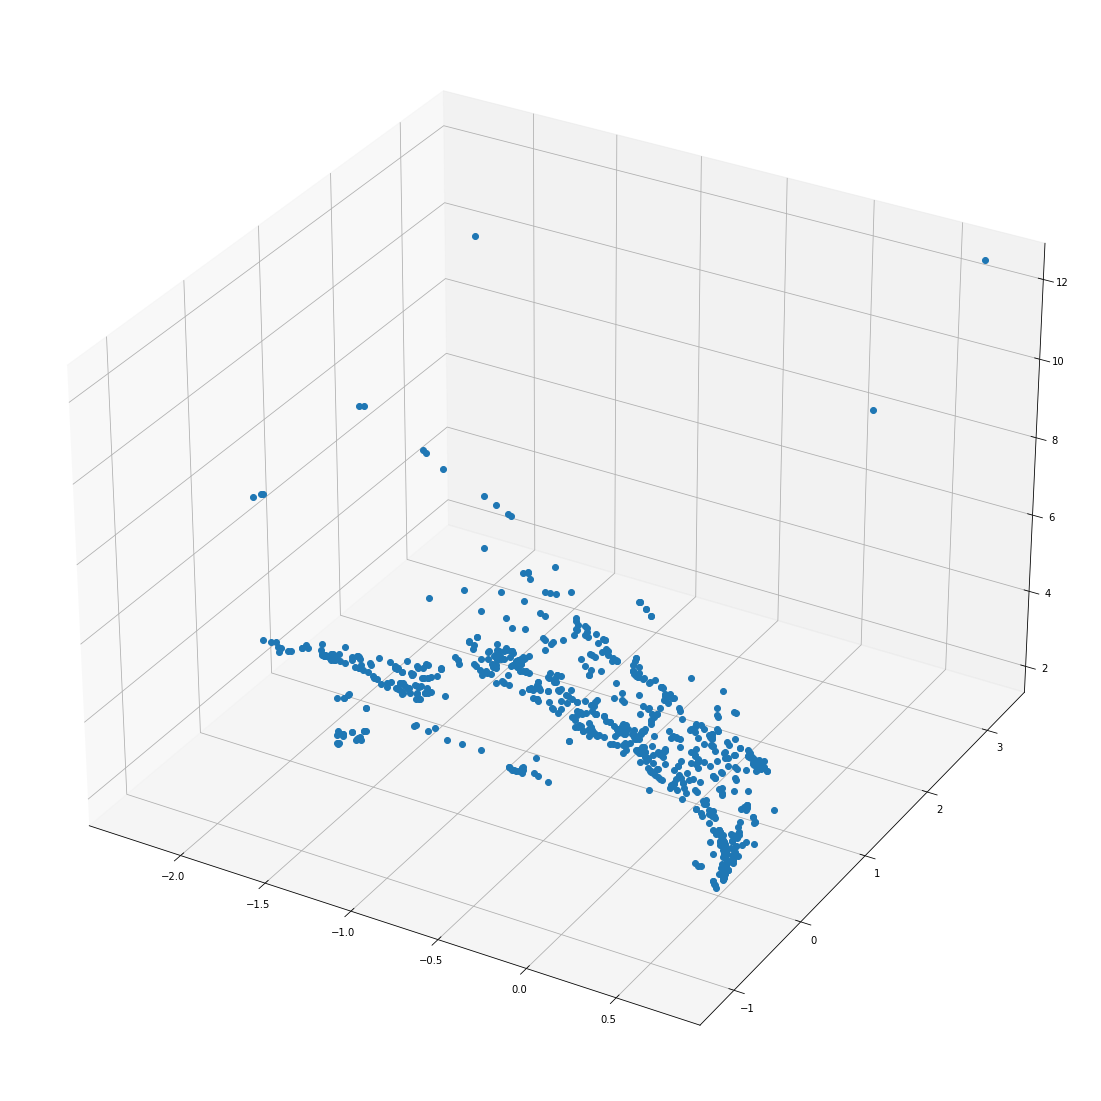

In [58]:
#3D plot
fig = plt.figure(figsize=[20,20])
ax=fig.gca(projection="3d") 
ax.view_init(elev=None, azim=None)
ax.plot(X[0], X[1], X[2], "o") 
plt.draw()
plt.show()

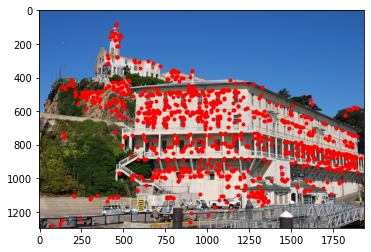

In [59]:
plt.figure()
plt.imshow(img2[:,:,::-1])
plt.plot(x2[0], x2[1], "r.") 

In [60]:
x2p = project(P2, X)
x2p = np.dot(K, x2p)

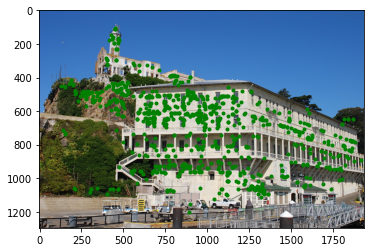

In [61]:
plt.figure()
plt.imshow(img2[:,:,::-1])
plt.plot(x2p[0], x2p[1], "g.")